In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import os
from scipy.linalg import circulant
from numpy import linalg as LA
import preprocess as pr
from keras.preprocessing import sequence
import keras
from keras.models import Sequential,Model
from keras.layers import Dense,Input,Conv1D,MaxPooling1D,Flatten,LSTM,Dropout,BatchNormalization,Activation,Concatenate

from keras.preprocessing import sequence
import re

Using TensorFlow backend.


In [2]:
os.chdir("/Polycarbon/hand Motion Clasification")

In [3]:
[1,5,6,9,10,14,15]

[1, 5, 6, 9, 10, 14, 15]

In [6]:
def read_in_folder(folder_path,gesture_name):
    x=[]
    y=[]
    for file in os.listdir(folder_path):
        if( "-L-" in file): 
            L_hand_file=  folder_path +"/"+file
            R_hand_file=  folder_path +"/"+ re.sub(r"-L-","-R-",file)
            dL=pr.read_emg(L_hand_file).dropna().astype(float)
            dR=pr.read_emg(R_hand_file).dropna().astype(float)
            if(gesture_name!="1"):
                if(dL.Time.size>900):
                    T1 =  pr.find_active_time(dL.Time,dL.loc[:,['gx','gy','gz']])
                    T2 =  pr.find_active_time(dR.Time,dR.loc[:,['gx','gy','gz']])
                    if (len(T1)==2):
                        T = (np.array(T1)+np.array(T2))/2
                        Lhand = dL[dL.Time>=T[0]].T.values[1:]
                        Rhand = dR[dR.Time>=T[0]].T.values[1:]
                        x.append([Lhand,Rhand])
                        y.append(gesture_name)
            else:
                Lhand = dL.T.values[1:]
                Rhand = dR.T.values[1:]
                x.append([Lhand,Rhand])
                y.append(gesture_name)
            #print("success :"+L_hand_file+"__"+R_hand_file)
    return x,y

x = []
y = []
for n,sample in enumerate(os.listdir("Data/")[11:60]):
    if(os.path.isdir("Data/"+sample) and sample!=".ipynb_checkpoints"):
        for i in range(1,16):
            filename = "M"+str(i)+"-"+sample  
            if len(os.listdir("Data/"+sample+"/"+filename))==2:
                for fd in os.listdir("Data/"+sample+"/"+filename):
                    filepath="Data/"+sample+"/"+filename+"/"+fd+"/"
                    u,v = read_in_folder(filepath,str(i)+fd.lower())
                    x.extend(u)
                    y.extend(v)
            else:
                filepath="Data/"+sample+"/"+filename
                u,v = read_in_folder(filepath,str(i))
                x.extend(u)
                y.extend(v)
    print("success "+str(n)+"/105 "+":"+sample)

C:\Users\Denice\Anaconda3\envs\tensorflow\lib\site-packages\numpy\core\fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Denice\Anaconda3\envs\tensorflow\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


success 0/105 :Buntra
success 1/105 :Charuves_Krasaerot
success 2/105 :Chatri
success 3/105 :Donsatid
success 4/105 :Duangporn
success 5/105 :Duenpen
success 6/105 :dusid
success 7/105 :Jamroen
success 8/105 :Jamroen_Murangkerd
success 9/105 :Jinda_Jaichuphan
success 10/105 :Jiratchaya
success 11/105 :Jittana Jaroenrak
success 12/105 :Kamon
success 13/105 :Karnda
success 14/105 :Keawta
success 15/105 :khanittha
success 16/105 :kobkeaw
success 17/105 :Ladawan
success 18/105 :lamphueng
success 19/105 :lamyong
success 20/105 :laong krue
success 21/105 :Lumyong
success 22/105 :Mayuree
success 23/105 :Mayuree2
success 24/105 :Mink
success 25/105 :Mongkhon
success 26/105 :Napas
success 27/105 :Narin
success 28/105 :Narin_Prang
success 29/105 :narumon
success 30/105 :Nittaya
success 31/105 :onsa
success 32/105 :Oranut
success 33/105 :Pagapan
success 34/105 :petch
success 35/105 :Phimjai saensut
success 36/105 :Pichaya
success 37/105 :Pikool
success 38/105 :pradit
success 39/105 :Prateep Angch

KeyboardInterrupt: 

In [41]:
from sklearn import preprocessing
encoder = preprocessing.LabelEncoder()
encoder.fit(y)
ye = encoder.transform(y)

In [40]:
y[y=="14left"]="14l"
y[y=="15left"]="15l"
y[y=="14right"]="14r"
y[y=="15right"]="15r"

In [42]:
encoder.classes_

array(['1', '10', '11', '12', '13', '14l', '14r', '15l', '15r', '2', '3',
       '4', '5', '6', '7', '8', '9'], dtype='<U7')

# Histogram of window lenght 

In [43]:
lenghts = [len(x[i][0][0]) for i in range(len(x))]
x=[x[i] for i,l in enumerate(lenghts) if(l>900)]
ye=[ye[i] for i,l in enumerate(lenghts) if(l>900)]

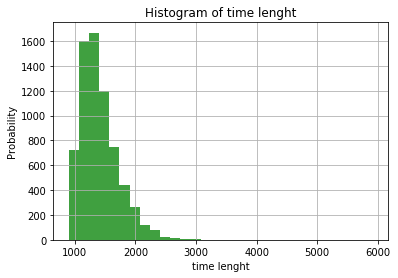

In [11]:

v = [len(x[i][0][0]) for i in range(len(x))]
# the histogram of the data
n, bins, patches = plt.hist(v, 30, density=False, facecolor='g', alpha=0.75)

mu = np.std(v)
sigma = np.average(v)
plt.xlabel('time lenght')
plt.ylabel('Probability')
plt.title('Histogram of time lenght')
# plt.text(500, 150, r'$\mu='+str(np.trunc(mu))+',\ \sigma='+str(np.trunc(sigma))+'$')0
plt.grid(True)
plt.show()

# build model function

In [151]:
def build_model(window_length,feature_length):
    input_signal = Input(shape=(feature_length,window_length),name="input_signal")
    x = Conv1D(filters=32, kernel_size=3,activation='relu', padding='same')(input_signal)
    x = MaxPooling1D(2, padding='same')(x)
    x = Conv1D(filters=16, kernel_size=200,activation='relu', padding='same')(x)
    x = MaxPooling1D(2, padding='same')(x)
    x = Conv1D(filters=8, kernel_size=200,activation='relu', padding='same')(x)
    x = MaxPooling1D(2, padding='same')(x)
#     x = LSTM(100, return_sequences=False)(x)
#     x = Dropout(0.5)(x)
    x = Flatten()(x)


    x = Dense(output_dim = 80, init = 'uniform', activation = 'relu')(x)
    dense_out = Dense(17, activation="sigmoid" ,name ="output_Dense")(x)
    
    model=Model(inputs=[input_signal], outputs=[dense_out])
        
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def build_model2(window_length,feature_length):
    input_signal = Input(shape=(feature_length,window_length),name="input_signal")
    x = LSTM(100, return_sequences=False)( input_signal)
    
    x = Dropout(0.5)(x)

    x = Dense(output_dim = 80, init = 'uniform', activation = 'relu')(x)
    dense_out = Dense(17, activation="sigmoid" ,name ="output_Dense")(x)
    
    model=Model(inputs=[input_signal], outputs=[dense_out])
        
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [158]:
len(x[0][0])

30

In [14]:
# #normalize
# g=np.array([normalize(x[0]) for i in range(len(y))])
#padding
XL=np.array([sequence.pad_sequences(b[0], padding="post",maxlen=2000,dtype='float32')for b in x])
XR=np.array([sequence.pad_sequences(b[1], padding="post",maxlen=2000,dtype='float32')for b in x])

In [210]:
X =np.concatenate((XL[:,16:], XR[:,16:]), axis=1)


In [211]:
X.shape

(6890, 28, 1984)

# feature Selection

['Smooth-Ch0','Smooth-Ch1','Smooth-Ch2','Smooth-Ch3','Smooth-Ch4','Smooth-Ch5','Smooth-Ch6','Smooth-Ch7','ax','ay','az','gx','gy','gz']

In [216]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X,ye,test_size=0.15,stratify=ye)

model=build_model(X.shape[2],X.shape[1])  
model.fit(X_train, pd.get_dummies(y_train), batch_size = 500, nb_epoch = 47)


C:\Users\Denice\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=80, kernel_initializer="uniform")`
  
C:\Users\Denice\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:5: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """


Epoch 1/47
5856/5856 [==============================] - 3s 500us/step - loss: 2.8355 - acc: 0.0546
Epoch 2/47
5856/5856 [==============================] - 1s 153us/step - loss: 2.8301 - acc: 0.0698
Epoch 3/47
5856/5856 [==============================] - 1s 153us/step - loss: 2.8134 - acc: 0.0777
Epoch 4/47
5856/5856 [==============================] - 1s 153us/step - loss: 2.7763 - acc: 0.0869
Epoch 5/47
5856/5856 [==============================] - 1s 155us/step - loss: 2.7082 - acc: 0.1006
Epoch 6/47
5856/5856 [==============================] - 1s 153us/step - loss: 2.6404 - acc: 0.1209
Epoch 7/47
5856/5856 [==============================] - 1s 153us/step - loss: 2.5474 - acc: 0.1395
Epoch 8/47
5856/5856 [==============================] - 1s 154us/step - loss: 2.4571 - acc: 0.1650
Epoch 9/47
5856/5856 [==============================] - 1s 152us/step - loss: 2.3812 - acc: 0.1836
Epoch 10/47
5856/5856 [==============================] - 1s 153us/step - loss: 2.2646 - acc: 0.2179
Epoch 11/

In [217]:
scores = model.evaluate([X_test], pd.get_dummies(y_test))
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

1034/1034 [==============================] - ETA:  - 1s 743us/step

acc: 43.52%


Confusion matrix, without normalization
[[28  0  1  2  2  4  1  1  8 10  3  2  0  2  0  1  1]
 [ 0 24 15  3  2  2  1  0  1  0  2  3  1  0  1  0  7]
 [ 1  6 35  7  3  4  1  1  0  1  0  0  0  1  0  0  0]
 [ 0  3  9 30 10  3  0  0  1  0  0  0  1  1  0  0  2]
 [ 1  2  4  9 26  7  3  2  1  2  1  1  0  1  0  0  0]
 [ 0  1  6  2  5 31  4  3  6  0  0  0  2  0  0  0  0]
 [ 3  1  5  6  1 10 23  4  4  0  1  0  0  1  1  0  0]
 [ 3  1  4  4  6  6  2 20  4  5  1  0  2  0  0  0  1]
 [ 3  1  0  0  3  4  1 10 30  4  2  0  0  0  1  0  0]
 [ 6  0  2  1  0  0  1  2  0 31  8  1  2  4  2  1  1]
 [ 0  3  0  0  2  4  0  0  0 15 24  5  2  0  1  1  4]
 [ 2  1  3  1  0  4  0  1  1  4  6 26  6  4  0  1  1]
 [ 5  0  1  2  1  2  2  1  0  6  3  6 26  4  1  1  0]
 [ 2  1  1  1  0  2  1  1  0  4  1  2 14 23  7  1  1]
 [ 1  6  2  2  1  0  2  3  0  1  0  3  1 12 20  4  3]
 [ 1  0  2  1  0  2  0  0  0  1  0  1  2  0 12 28 10]
 [ 0 10  6  0  1  0  0  1  1  1  0  0  0  5  3  7 25]]


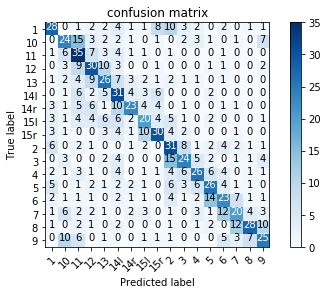

Normalized confusion matrix
[[0.42 0.   0.02 0.03 0.03 0.06 0.02 0.02 0.12 0.15 0.05 0.03 0.   0.03
  0.   0.02 0.02]
 [0.   0.39 0.24 0.05 0.03 0.03 0.02 0.   0.02 0.   0.03 0.05 0.02 0.
  0.02 0.   0.11]
 [0.02 0.1  0.58 0.12 0.05 0.07 0.02 0.02 0.   0.02 0.   0.   0.   0.02
  0.   0.   0.  ]
 [0.   0.05 0.15 0.5  0.17 0.05 0.   0.   0.02 0.   0.   0.   0.02 0.02
  0.   0.   0.03]
 [0.02 0.03 0.07 0.15 0.43 0.12 0.05 0.03 0.02 0.03 0.02 0.02 0.   0.02
  0.   0.   0.  ]
 [0.   0.02 0.1  0.03 0.08 0.52 0.07 0.05 0.1  0.   0.   0.   0.03 0.
  0.   0.   0.  ]
 [0.05 0.02 0.08 0.1  0.02 0.17 0.38 0.07 0.07 0.   0.02 0.   0.   0.02
  0.02 0.   0.  ]
 [0.05 0.02 0.07 0.07 0.1  0.1  0.03 0.34 0.07 0.08 0.02 0.   0.03 0.
  0.   0.   0.02]
 [0.05 0.02 0.   0.   0.05 0.07 0.02 0.17 0.51 0.07 0.03 0.   0.   0.
  0.02 0.   0.  ]
 [0.1  0.   0.03 0.02 0.   0.   0.02 0.03 0.   0.5  0.13 0.02 0.03 0.06
  0.03 0.02 0.02]
 [0.   0.05 0.   0.   0.03 0.07 0.   0.   0.   0.25 0.39 0.08 0.03 0.
  0.02 0.0

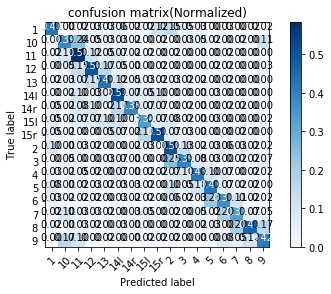

In [218]:
def get_predict(model,X):

    array_p=model.predict([X])
    predict=[np.argmax(i) for i in array_p]
    return  np.array(predict)

prd = get_predict(model,X_test)
pr.confuse_matrix_plot(y_test,prd,encoder.classes_,title="confusion matrix")

In [170]:
x1 =  x[10][0]

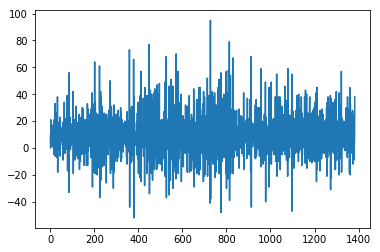

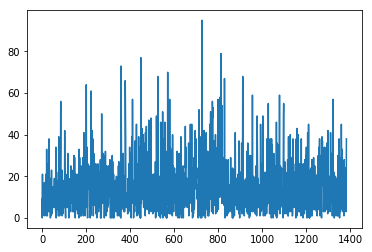

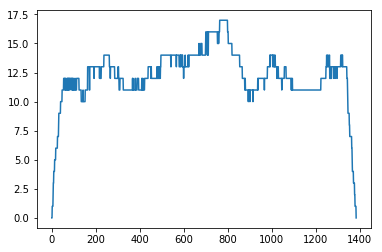

In [178]:
from scipy import signal
x1 =  x[11][0]
plt.plot(x1[0])
plt.show()
plt.plot(x1[8])
plt.show()
y1 = signal.medfilt(x1[8],101) 
plt.plot(y1)
plt.show()

In [198]:
len(x1[:8])
x1[:8]= [signal.medfilt(ch,21)  for ch in x1[:8]]           

In [202]:
X.shape

(6890, 28, 1000)

In [209]:
x

ValueError: could not broadcast input array from shape (30,3018) into shape (30)

In [60]:
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


def confuse_matrix_plot(Y,Pred,list_class,title="confusion matrix"):
    
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(Y, Pred)
    np.set_printoptions(precision=2)

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=list_class, normalize=False,
                          title=title)
    plt.show()
      # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=list_class, normalize=True,
                          title=title +'(Normalized)')
    plt.show()
